In [1]:
import numpy as np

In [2]:
def dilser(low=0.001, limit=100.0, dilfactor = 2.0):
    """Returns a list containing a dilution series that ranges from
    "low" to "limit" by "dilfactor".
    """
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    
    return np.array(a)

In [3]:
lig = dilser()

In [4]:
a = np.delete(lig,[15,16])

In [5]:
b = np.delete(lig,[14,17])

In [6]:
c = np.delete(lig,[13,15])

In [7]:
ligset = np.array([lig,a,lig,b,c])

In [8]:
noiseset = np.array([np.random.normal(1,0.05,ligset[i].size) for i in range(ligset.shape[0])])

In [9]:
rtots = np.array([0.001,0.005, 0.01, 0.02, 0.05])

In [10]:
sim_parms = dict({'k11':3.75, 'k21':1.81, 'k22':0.115, 'l20':283.0})

In [11]:
def wyman_sim(lig,rtot,parm):
    """
    returns bound fraction for model of aggregating system as described by Wyman and implemened
    by Pike
    
    lig 
    -------
    is an array of arrays (created from a list of arrays -- because
    datasets may not have a uniform number of data points in each experiment)
    
    this is important for the loop below that uses lig.size to generate indices. if lig 
    was a proper array, size would be the total number of cells, but in this case it is the 
    number of arrays (or experimental data sets) in the array
    
    rtot 
    -------
    is a 1d array (but may work as other data structure -- test this)
    
    parm
    -------
    dict of parameter names and values or a Parameters object from the lmfit package
     
    """
    #assign parameter values
    k11 = parm['k11']
    k21 = parm['k21']
    k22 = parm['k22']
    l20 = parm['l20']
    
    holder = []
    
    for i in range(lig.size):
        rfree = (((-1 - k11*lig[i]) + \
        (np.sqrt((1 + k11*lig[i])**2 + 8*l20*rtot[i]*(1 + k21*lig[i] + \
        k21*k22*(lig[i]**2)))))/(4*l20*(1 + k21*lig[i] + k21*k22*(lig[i]**2))))
        
        bfrac = (k11*lig[i] + l20*k21*rfree*lig[i] + \
        2*l20*k21*k22*rfree*(lig[i]**2))/(1 + 2*l20*rfree + k11*lig[i] + \
        2*l20*k21*rfree*lig[i] + 2*l20*k21*k22*rfree*(lig[i]**2))
        
        holder.append(bfrac)
        
    return np.array(holder)

In [12]:
bindset = wyman_sim(ligset,rtots,sim_parms)

In [13]:
import matplotlib.pyplot as plt

In [14]:
%matplotlib inline

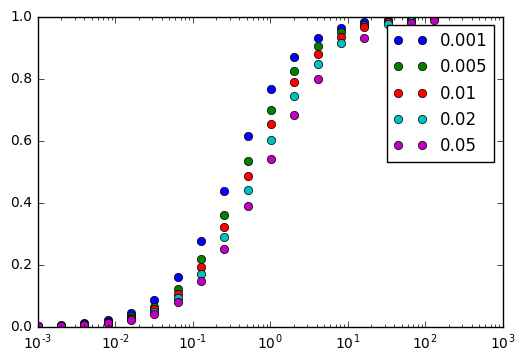

In [15]:
for i in range(bindset.size):
    plt.semilogx(ligset[i],bindset[i], 'o', label=str(rtots[i]))
    plt.legend()

In [16]:
bindset_n = bindset*noiseset

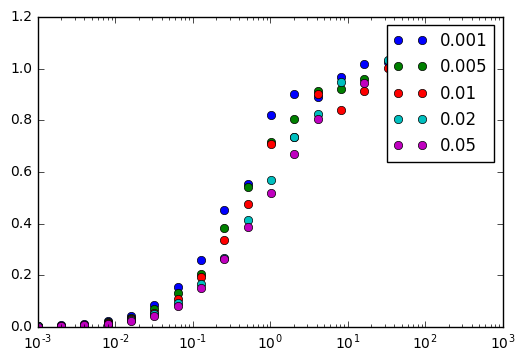

In [17]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',label=str(rtots[i]))
    plt.legend()

In [19]:
err = 0.05*bindset_n

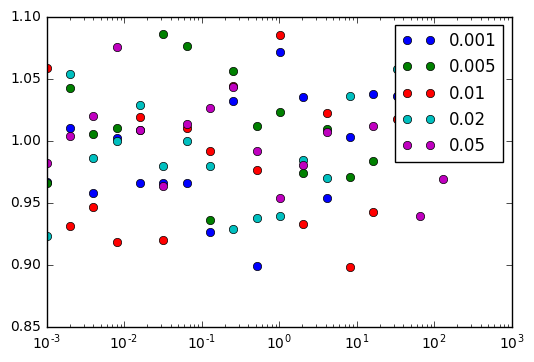

In [21]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],noiseset[i],'o',label=str(rtots[i]))
    plt.legend()

In [33]:
def wym_obj2(parm,lig,rtot,data,eps=None):
    """
    parms
    --------
    lmfit.Parameters() object containin definitions for k11, k21, k22, and l20
    
    x
    --------
    array of arrays (probably assymetric elements without "formal" dimensions) containing 
    free ligand concentrations, must be of same size (no. of elements) as rtots, and same "shape"
    as data (same number of arrays within the array and the same number of elements in each subarray)
    
    Continue documentation
    """
    
    k11 = parm['k11']
    k21 = parm['k21']
    k22 = parm['k22']
    l20 = parm['l20']
    
    model = []
    
    for i in range(lig.size):
        rfree = (((-1 - k11*lig[i]) + \
        (np.sqrt((1 + k11*lig[i])**2 + 8*l20*rtot[i]*(1 + k21*lig[i] + \
        k21*k22*(lig[i]**2)))))/(4*l20*(1 + k21*lig[i] + k21*k22*(lig[i]**2))))
        
        bfrac = (k11*lig[i] + l20*k21*rfree*lig[i] + \
        2*l20*k21*k22*rfree*(lig[i]**2))/(1 + 2*l20*rfree + k11*lig[i] + \
        2*l20*k21*rfree*lig[i] + 2*l20*k21*k22*rfree*(lig[i]**2))
        
        model.append(bfrac)
        
    if eps is None:
        return np.concatenate((np.array(model)) - data)
    else:
        weights = 1/(np.square(eps))
        return np.concatenate(((np.array(model)) - data)*weights)

In [23]:
import lmfit

In [24]:
parms = lmfit.Parameters()

In [25]:
parms.add('k11', value=10., min=0.01)
parms.add('k21', value=10., min=0.01)
parms.add('k22', value=10., min=0.01)
parms.add('l20', value=100., min=0.01)

In [34]:
wyminner_wts = lmfit.Minimizer(wym_obj2,parms,fcn_args=(ligset,rtots,bindset_n,err))

In [44]:
result = wyminner_wts.minimize(method='least_squares', loss='soft_l1')

In [45]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # function evals   = 258
    # data points      = 84
    # variables        = 4
    chi-square         = 693033184.155
    reduced chi-square = 8662914.802
    Akaike info crit   = 1345.765
    Bayesian info crit = 1355.488
[[Variables]]
    k11:   3.67556952 (init= 10)
    k21:   1.83574785 (init= 10)
    k22:   0.45810231 (init= 10)
    l20:   315.746244 (init= 100)
[[Correlations]] (unreported correlations are <  0.100)


In [48]:
def lnprob2(parm,x,rtot,data,eps=None):
    return -0.5 * np.sum((wym_obj2(parm,x,rtot,data,eps))**2 + np.log(np.concatenate(2 * np.pi * eps**2)))

In [49]:
lnprob2(result.params,ligset,rtots,bindset_n,err)

-346516248.24807245

In [50]:
mcmc = lmfit.Minimizer(lnprob2, result.params, fcn_args=(ligset,rtots,bindset_n,err))

In [54]:
result_mc = mcmc.emcee(burn=500, steps=5000, thin=10, params=result.params)

In [52]:
import corner

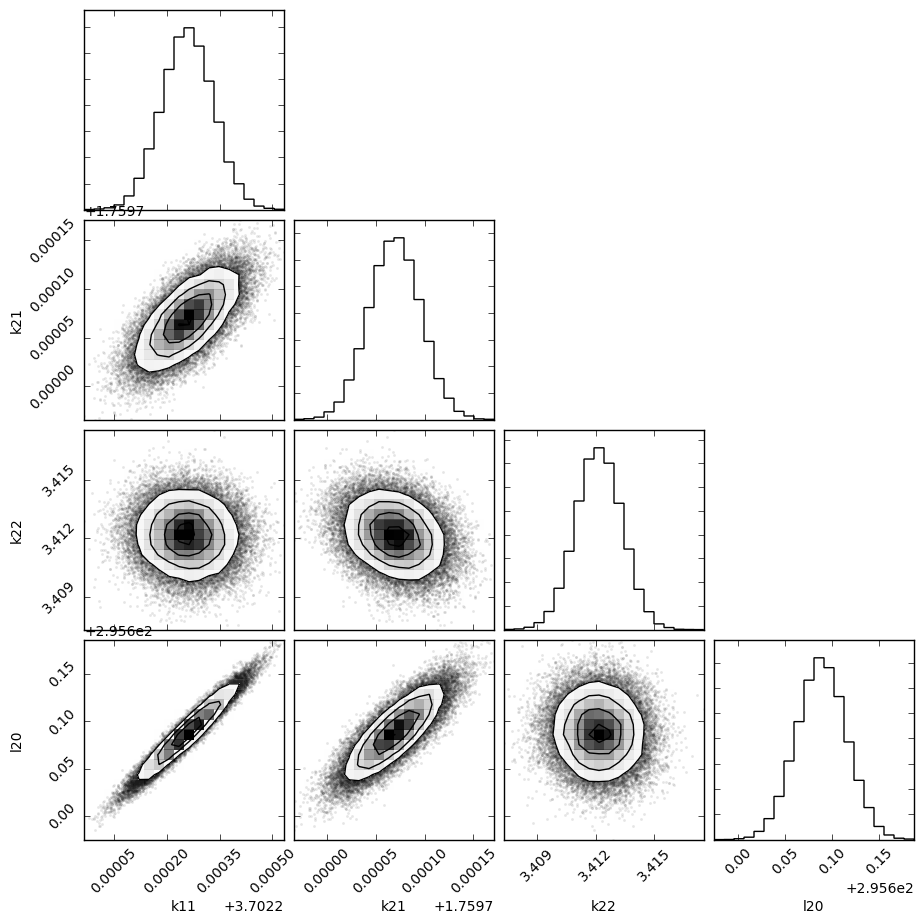

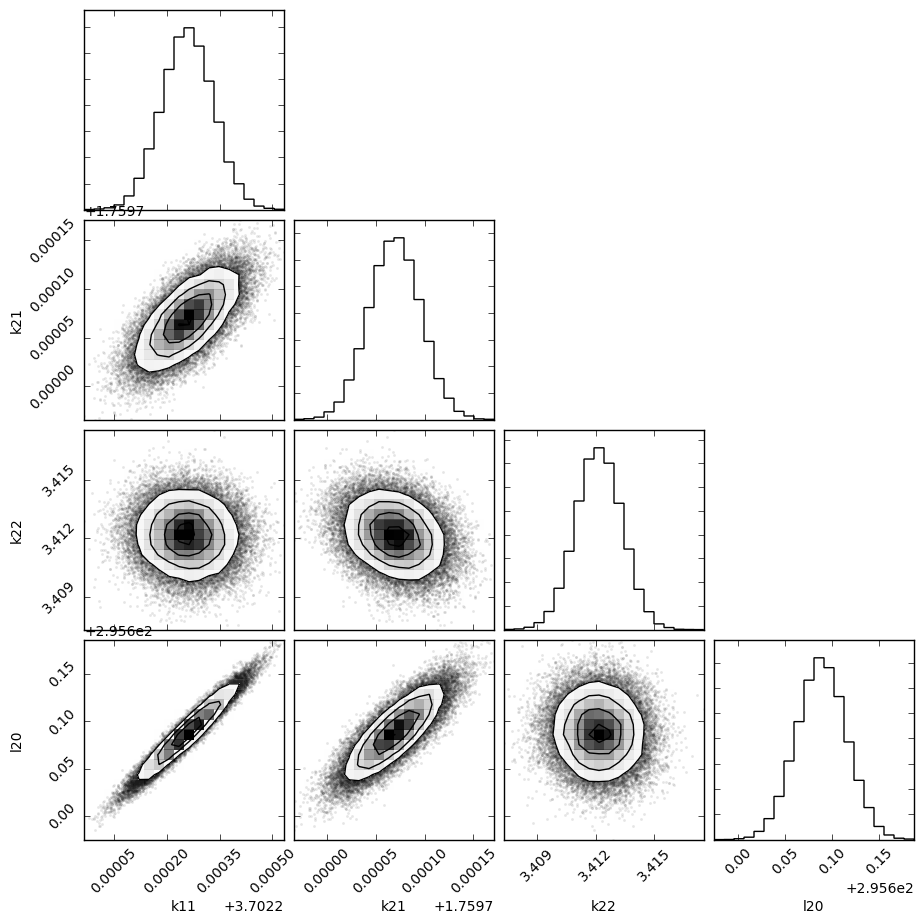

In [55]:
corner.corner(result_mc.flatchain)

In [56]:
result.params

Parameters([('k11', <Parameter 'k11', 3.6755695205170311, bounds=[0.01:inf]>),
            ('k21', <Parameter 'k21', 1.8357478565506304, bounds=[0.01:inf]>),
            ('k22', <Parameter 'k22', 0.45810231702368737, bounds=[0.01:inf]>),
            ('l20', <Parameter 'l20', 315.74624463865354, bounds=[0.01:inf]>)])

In [57]:
result_mc.params

Parameters([('k11',
             <Parameter 'k11', value=3.7024589273068105 +/- 7.26e-05, bounds=[0.01:inf]>),
            ('k21',
             <Parameter 'k21', value=1.759769427516471 +/- 2.64e-05, bounds=[0.01:inf]>),
            ('k22',
             <Parameter 'k22', value=3.4121693874912324 +/- 0.00118, bounds=[0.01:inf]>),
            ('l20',
             <Parameter 'l20', value=295.68856317589473 +/- 0.0264, bounds=[0.01:inf]>)])

NameError: name 'sim_parms' is not defined